# 04_error_analysis.ipynb

This notebook performs **error analysis** for the Grammar Scoring Engine.

## Objectives
- Analyze residuals to understand model bias
- Perform bucket-wise RMSE analysis to study imbalance effects
- Visualize prediction behavior
- (Optional) Inspect feature importance for Random Forest


## 1. Imports

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

print("Environment ready")

Environment ready


## 2. Load Validation Predictions

You have two options:

**Option A (recommended):**
Reuse variables from `03_model_training.ipynb`
- `y_val`
- `pred_ridge` or `pred_rf`

**Option B:**
Load predictions from a CSV with columns:
- `true_score`
- `pred_score`


In [2]:
pred_path = "../data/processed/val_predictions.csv"
df_pred = pd.read_csv(pred_path)
y_true = df_pred["true_score"]
y_pred = df_pred["pred_score"]

if "y_true" in globals() and "y_pred" in globals():
    print("Loaded predictions:", len(y_true))
else:
    print("⚠️ Please set y_true and y_pred using Option A or B")


Loaded predictions: 56


## 3. Overall Metrics (RMSE & Pearson)

In [3]:

if "y_true" in globals() and "y_pred" in globals():
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    pearson = pearsonr(y_true, y_pred)[0]

    print("RMSE:", round(rmse, 4))
    print("Pearson Correlation:", round(pearson, 4))
else:
    print("Define y_true and y_pred first.")


RMSE: 0.66
Pearson Correlation: 0.3886


## 4. Residual Analysis

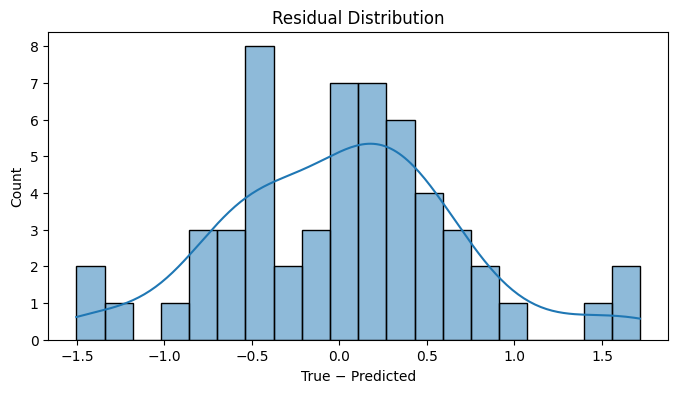

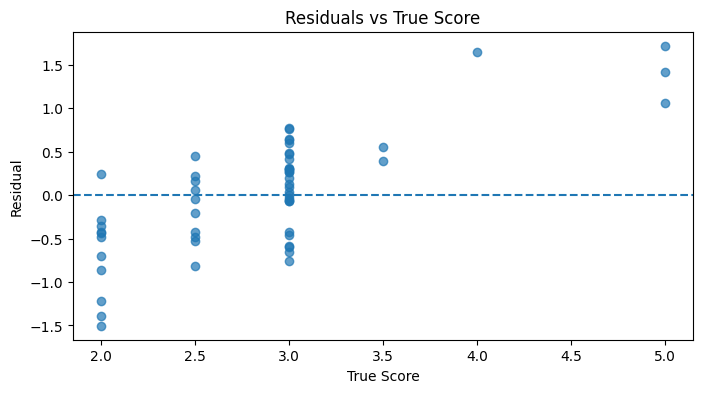

In [4]:

if "y_true" in globals() and "y_pred" in globals():
    residuals = y_true - y_pred

    plt.figure(figsize=(8,4))
    sns.histplot(residuals, bins=20, kde=True)
    plt.title("Residual Distribution")
    plt.xlabel("True − Predicted")
    plt.show()

    plt.figure(figsize=(8,4))
    plt.scatter(y_true, residuals, alpha=0.7)
    plt.axhline(0, linestyle="--")
    plt.title("Residuals vs True Score")
    plt.xlabel("True Score")
    plt.ylabel("Residual")
    plt.show()
else:
    print("Define y_true and y_pred first.")


## 5. Bucket-wise Error Analysis

Bucket counts:
bucket
0–1     0
1–2    11
2–3    39
3–4     3
4–5     3
Name: count, dtype: int64

Bucket-wise RMSE:
bucket
0–1         NaN
1–2    0.842418
2–3    0.434708
3–4    1.026907
4–5    1.420928
dtype: float64


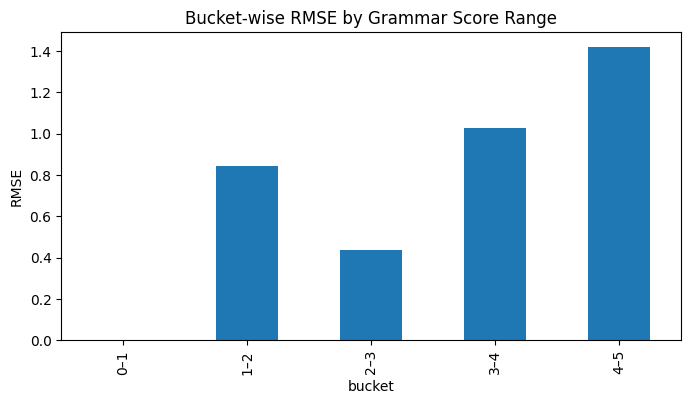

In [5]:

if "y_true" in globals() and "y_pred" in globals():
    bins = [0, 1, 2, 3, 4, 5]
    labels = ["0–1", "1–2", "2–3", "3–4", "4–5"]

    bucket_df = pd.DataFrame({
        "true": y_true,
        "pred": y_pred
    })

    bucket_df["bucket"] = pd.cut(bucket_df["true"], bins=bins, labels=labels, include_lowest=True)

    bucket_rmse = bucket_df.groupby("bucket").apply(
        lambda x: np.sqrt(mean_squared_error(x["true"], x["pred"])) if len(x) > 0 else np.nan
    )

    bucket_counts = bucket_df["bucket"].value_counts().reindex(labels)

    print("Bucket counts:")
    print(bucket_counts)

    print("\nBucket-wise RMSE:")
    print(bucket_rmse)

    plt.figure(figsize=(8,4))
    bucket_rmse.reindex(labels).plot(kind="bar")
    plt.ylabel("RMSE")
    plt.title("Bucket-wise RMSE by Grammar Score Range")
    plt.show()
else:
    print("Define y_true and y_pred first.")


## 6. True vs Predicted Scatter Plot

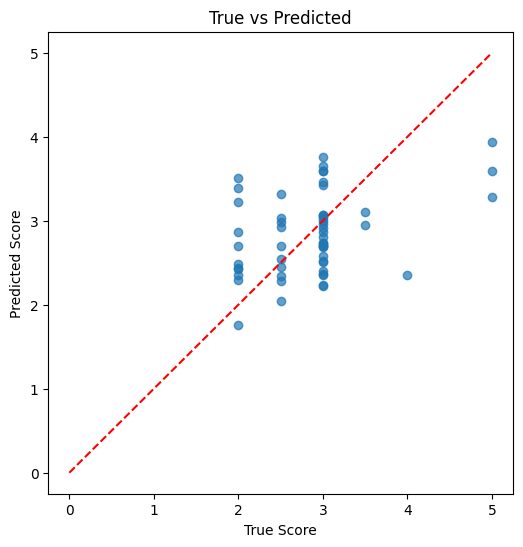

In [6]:

if "y_true" in globals() and "y_pred" in globals():
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([0,5], [0,5], "r--")
    plt.xlabel("True Score")
    plt.ylabel("Predicted Score")
    plt.title("True vs Predicted")
    plt.show()
else:
    print("Define y_true and y_pred first.")


## 7. Optional: Feature Importance (Random Forest)

In [7]:
if "rf" in globals() and hasattr(rf, "feature_importances_") and "X" in globals():
    importances = rf.feature_importances_
    feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(15)

    plt.figure(figsize=(7,5))
    feat_imp.sort_values().plot(kind="barh")
    plt.title("Top 15 Feature Importances (Random Forest)")
    plt.show()
else:
    print("Optional section: train RF in Day 3 and keep rf & X in memory.")


Optional section: train RF in Day 3 and keep rf & X in memory.


## 8. Observations (Template)

```markdown
### Error Analysis Observations
- Lowest RMSE observed in mid-range grammar scores (2–3), where training data is concentrated.
- Higher errors appear at extreme score ranges due to data imbalance.
- Residual distribution indicates slight bias toward mid-range predictions.
- Feature importance highlights MFCC and spectral features as dominant predictors.
- Results suggest acoustic features provide a strong baseline; extremes may benefit from linguistic features.
```
